In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io
import math 
import sklearn 
import sklearn.datasets 

import usr_func

%load_ext autoreload
%autoreload 2


In [18]:
def update_parameters_with_gd(parameters, grads, learning_rate): 
    L = len(parameters) // 2

    for l in range(L): 
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]

    return parameters

def random_mini_batches(X, Y, mini_batch_size=64, seed=0): 
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches): 
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def initialize_velocity(parameters): 
    L = len(parameters) // 2
    v = {}

    for l in range(L): 
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2

    for l in range(L): 
        v['dW' + str(l+1)] = beta * v['dW' + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta * v['db' + str(l+1)] + (1-beta) * grads['db' + str(l+1)]

        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v['db' + str(l+1)]
    
    return parameters, v

def initialize_adam(parameters): 
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(L): 
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=.01, beta1=.9, beta2=.999, epsilon=1e-8): 
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(L): 
        v['dW' + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta1 * v['db' + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]

        v_corrected['dW' + str(l+1)] = v['dW' + str(l+1)] / (1 - beta1**t)
        v_corrected['db' + str(l+1)] = v['db' + str(l+1)] / (1 - beta1**t)

        s['dW' + str(l+1)] = beta2 * s['dW' + str(l+1)] + (1-beta2) * grads['dW' + str(l+1)]**2
        s['db' + str(l+1)] = beta2 * s['db' + str(l+1)] + (1-beta2) * grads['db' + str(l+1)]**2

        s_corrected['dW' + str(l+1)] = s['dW' + str(l+1)] / (1 - beta2**t)
        s_corrected['db' + str(l+1)] = s['db' + str(l+1)] / (1 - beta2**t)

        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon)
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v_corrected['db' + str(l+1)] / (np.sqrt(s_corrected['db' + str(l+1)]) + epsilon)
    
    return parameters, v, s

def model(X, Y, layers_dims, optimizer, learning_rate=.0007, mini_batch_size=64, beta=.9, beta1=.9, beta2=.999, epsilon=1e-8, num_epochs=10000, print_cost=True): 
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]

    parameters = usr_func.initialize_parameters(layers_dims)

    if optimizer == 'gd': 
        pass
    elif optimizer == 'momentum': 
        v = initialize_velocity(parameters)
    elif optimizer == 'adam': 
        v, s = initialize_adam(parameters)

    for i in range(num_epochs): 
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches: 
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = usr_func.forward_propagation(minibatch_X, parameters)
            cost_total += usr_func.compute_cost(a3, minibatch_Y)
            grads = usr_func.backward_propagation(minibatch_X, minibatch_Y, caches)

            if optimizer == 'gd': 
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == 'momentum': 
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam': 
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        cost_avg = cost_total / m

        if print_cost and i % 100 == 0: 
            print('Cost after epoch %i: %f' % (i, cost_avg))
        if print_cost and i % 100 == 0: 
            costs.append(cost_avg)
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.702405
Cost after epoch 100: 0.698199
Cost after epoch 200: 0.694321
Cost after epoch 300: 0.690613
Cost after epoch 400: 0.687161
Cost after epoch 500: 0.683902
Cost after epoch 600: 0.680792
Cost after epoch 700: 0.677676
Cost after epoch 800: 0.674580
Cost after epoch 900: 0.671374
Cost after epoch 1000: 0.668101
Cost after epoch 1100: 0.664843
Cost after epoch 1200: 0.661555
Cost after epoch 1300: 0.658303
Cost after epoch 1400: 0.655213
Cost after epoch 1500: 0.652123
Cost after epoch 1600: 0.648990
Cost after epoch 1700: 0.645715
Cost after epoch 1800: 0.642393
Cost after epoch 1900: 0.638909
Cost after epoch 2000: 0.635288
Cost after epoch 2100: 0.631647
Cost after epoch 2200: 0.628004
Cost after epoch 2300: 0.624317
Cost after epoch 2400: 0.620766
Cost after epoch 2500: 0.617265
Cost after epoch 2600: 0.613778
Cost after epoch 2700: 0.610325
Cost after epoch 2800: 0.606945
Cost after epoch 2900: 0.603728
Cost after epoch 3000: 0.600491
Cost after epoch 310

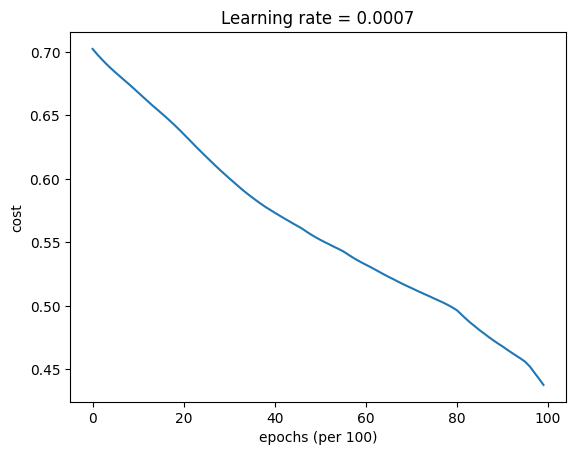

Accuracy: 0.7966666666666666


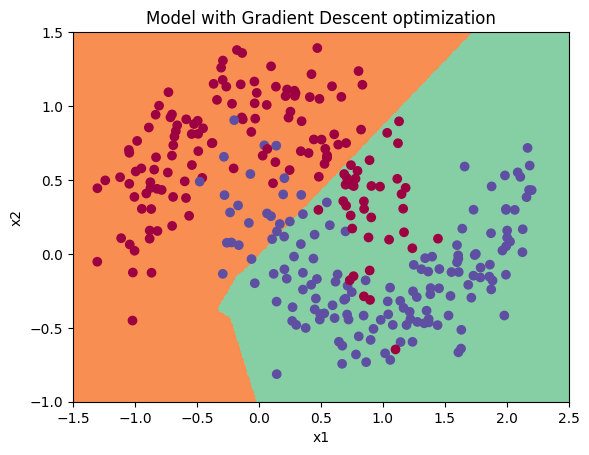

In [22]:
x_train, y_train = usr_func.load_dataset()
# plt.scatter(x_train[0, :], x_train[1, :], c=y_train, s=40, cmap=plt.cm.Spectral)
layers_dims = [x_train.shape[0], 5, 2, 1]
parameters = model(x_train, y_train, layers_dims, optimizer='gd')
predictions = usr_func.predict(x_train, y_train, parameters)

plt.title('Model with Gradient Descent optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
usr_func.plot_decision_boundary(lambda x: usr_func.predict_dec(parameters, x.T), x_train, y_train)

Cost after epoch 0: 0.702413
Cost after epoch 100: 0.698270
Cost after epoch 200: 0.694385
Cost after epoch 300: 0.690677
Cost after epoch 400: 0.687217
Cost after epoch 500: 0.683960
Cost after epoch 600: 0.680847
Cost after epoch 700: 0.677731
Cost after epoch 800: 0.674641
Cost after epoch 900: 0.671440
Cost after epoch 1000: 0.668167
Cost after epoch 1100: 0.664914
Cost after epoch 1200: 0.661624
Cost after epoch 1300: 0.658370
Cost after epoch 1400: 0.655276
Cost after epoch 1500: 0.652190
Cost after epoch 1600: 0.649061
Cost after epoch 1700: 0.645791
Cost after epoch 1800: 0.642475
Cost after epoch 1900: 0.639000
Cost after epoch 2000: 0.635388
Cost after epoch 2100: 0.631743
Cost after epoch 2200: 0.628104
Cost after epoch 2300: 0.624420
Cost after epoch 2400: 0.620866
Cost after epoch 2500: 0.617368
Cost after epoch 2600: 0.613878
Cost after epoch 2700: 0.610426
Cost after epoch 2800: 0.607045
Cost after epoch 2900: 0.603828
Cost after epoch 3000: 0.600591
Cost after epoch 310

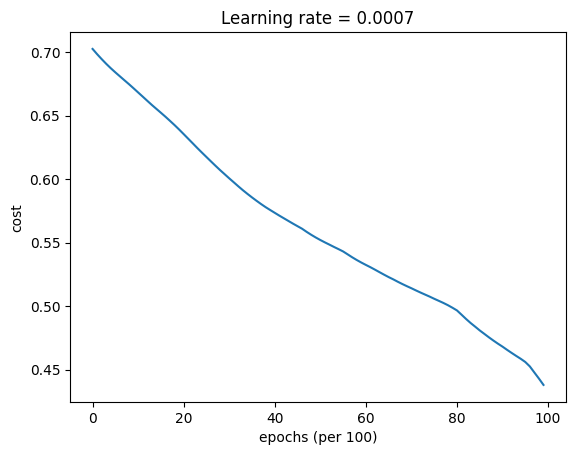

Accuracy: 0.7966666666666666


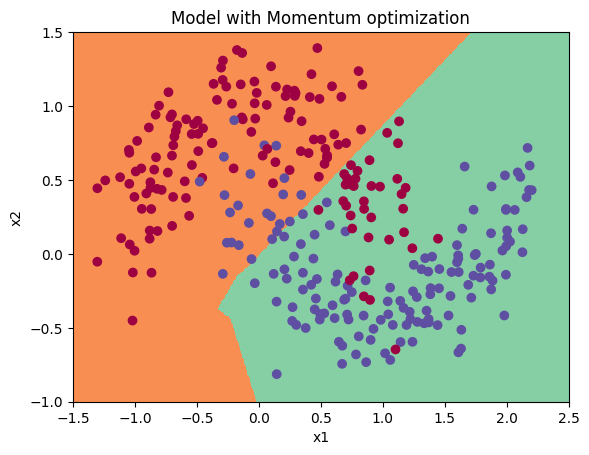

In [23]:
layers_dims = [x_train.shape[0], 5, 2, 1]
parameters = model(x_train, y_train, layers_dims, beta=.9, optimizer='momentum')
predictions = usr_func.predict(x_train, y_train, parameters)

plt.title('Model with Momentum optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
usr_func.plot_decision_boundary(lambda x: usr_func.predict_dec(parameters, x.T), x_train, y_train)


Cost after epoch 0: 0.702166
Cost after epoch 100: 0.587180
Cost after epoch 200: 0.499637
Cost after epoch 300: 0.366167
Cost after epoch 400: 0.300348
Cost after epoch 500: 0.256887
Cost after epoch 600: 0.226925
Cost after epoch 700: 0.205042
Cost after epoch 800: 0.188295
Cost after epoch 900: 0.177678
Cost after epoch 1000: 0.167845
Cost after epoch 1100: 0.159666
Cost after epoch 1200: 0.154810
Cost after epoch 1300: 0.151282
Cost after epoch 1400: 0.148563
Cost after epoch 1500: 0.146492
Cost after epoch 1600: 0.144928
Cost after epoch 1700: 0.143601
Cost after epoch 1800: 0.142605
Cost after epoch 1900: 0.141833
Cost after epoch 2000: 0.141316
Cost after epoch 2100: 0.140742
Cost after epoch 2200: 0.140425
Cost after epoch 2300: 0.139961
Cost after epoch 2400: 0.139782
Cost after epoch 2500: 0.139450
Cost after epoch 2600: 0.139233
Cost after epoch 2700: 0.139065
Cost after epoch 2800: 0.138934
Cost after epoch 2900: 0.138804
Cost after epoch 3000: 0.138788
Cost after epoch 310

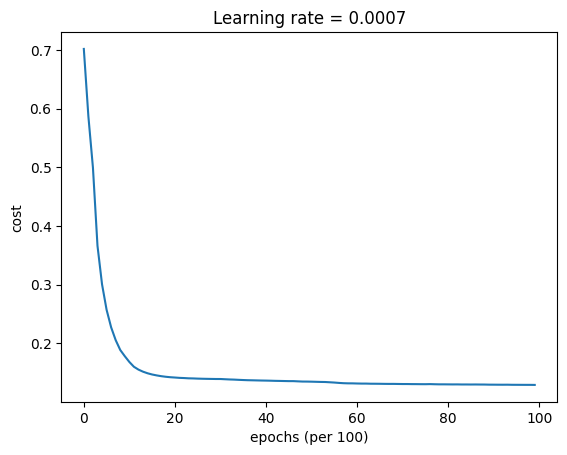

Accuracy: 0.94


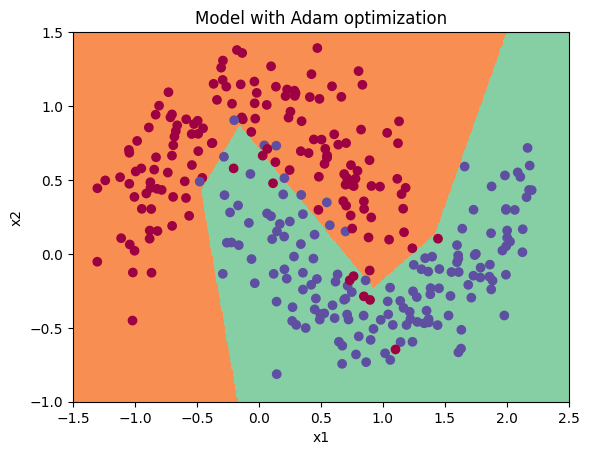

In [24]:
layers_dims = [x_train.shape[0], 5, 2, 1]
parameters = model(x_train, y_train, layers_dims, optimizer='adam')
predictions = usr_func.predict(x_train, y_train, parameters)

plt.title('Model with Adam optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
usr_func.plot_decision_boundary(lambda x: usr_func.predict_dec(parameters, x.T), x_train, y_train)